In [1]:
import cv2
import numpy as np
import os
from random import shuffle
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
TRAIN_DIR = 'dataset/training_set'
IMG_SIZE = 64
LR = 1e-3
MODEL_NAME = 'dogs-vs-cats-convnet'

In [3]:
def create_label(img_name):
    word_label = img_name.split('.')[-3]
    if word_label == 'cat':
        return np.int32(0)
    else:
        return np.int(1)

In [4]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        path = os.path.join(TRAIN_DIR,img)
        img_data = cv2.imread(path)
        #print(path)
        img_data = cv2.resize(img_data,(IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img_data),create_label(img)])
    shuffle(training_data)
    np.save('dataset/train_data.npy',training_data)
    return training_data

In [5]:
train_data = create_train_data()

100%|██████████| 8000/8000 [-5:01:38<00:00, -0.45it/s]


(8000, 2)


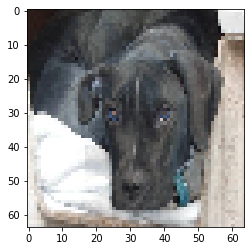

In [6]:
print(np.array(train_data).shape)
plt.imshow(train_data[55][0])

In [7]:
# split and reshape data to 50X50
print(len(train_data))
train = train_data[:-200]
test = train_data[-500:]
X_train = np.array([i[0] for i in train]).reshape([-1,IMG_SIZE,IMG_SIZE,3])
y_train = [i[1] for i in train]

X_test = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y_test = [i[1] for i in test]

8000


In [8]:
#Using Buitin CNN
from tensorflow.python.framework import ops
ops.reset_default_graph()
from tensorflow.keras.layers import Input,Conv2D,Dropout,MaxPool2D,Dense,Flatten,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from keras.applications.vgg16 import VGG16


#model = VGG16(include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
model = Sequential()

# A conv layer with 32 filters and 5 strides with fun relu
model.add(Conv2D(filters=64,kernel_size=(3,3),activation="relu",kernel_initializer="he_uniform",padding='same',input_shape=[IMG_SIZE,IMG_SIZE,3]))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128,kernel_size=(3,3),activation="relu",kernel_initializer="he_uniform"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=512,kernel_size=(3,3),activation="relu",kernel_initializer="he_uniform"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=1024,kernel_size=(3,3),activation="relu",kernel_initializer="he_uniform"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
          
model.add(Flatten())
    
#Fully CONNECTED Layer with 1024 neurons
model.add(Dense(1024,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.8))
model.add(Dense(1,activation="sigmoid"))
#A dropout with keep probab of 0.8 to finish the model
opt = SGD(learning_rate=0.001,momentum=0.9)
model.compile(optimizer=opt,loss="binary_crossentropy",metrics=['accuracy'])

Using TensorFlow backend.


In [9]:
print(X_train.shape)
print(len(y_train))
print(X_test.shape)
print(len(y_test))
model.summary()


(7800, 64, 64, 3)
7800
(500, 64, 64, 3)
500
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 128)       512       
_________________________________________________________________
max_pooling2

In [10]:

model.fit(X_train,np.array(y_train),epochs=50,validation_data=(X_test,np.array(y_test)),batch_size=100,verbose=1)

Epoch 1/50
78/78 [==============================] - 224s 3s/step - loss: 1.1536 - accuracy: 0.5590 - val_loss: 1.0398 - val_accuracy: 0.5280
Epoch 2/50
78/78 [==============================] - 221s 3s/step - loss: 0.8946 - accuracy: 0.5859 - val_loss: 0.6040 - val_accuracy: 0.6600
Epoch 3/50
78/78 [==============================] - 234s 3s/step - loss: 0.7567 - accuracy: 0.6053 - val_loss: 0.6016 - val_accuracy: 0.6740
Epoch 4/50
78/78 [==============================] - 238s 3s/step - loss: 0.6873 - accuracy: 0.6219 - val_loss: 0.5892 - val_accuracy: 0.6920
Epoch 5/50
78/78 [==============================] - 234s 3s/step - loss: 0.6463 - accuracy: 0.6356 - val_loss: 0.5844 - val_accuracy: 0.6940
Epoch 6/50
78/78 [==============================] - 226s 3s/step - loss: 0.6497 - accuracy: 0.6387 - val_loss: 0.5723 - val_accuracy: 0.7040
Epoch 7/50
78/78 [==============================] - 230s 3s/step - loss: 0.6416 - accuracy: 0.6445 - val_loss: 0.6158 - val_accuracy: 0.6820
Epoch 8/50
78

In [18]:
import keras
model.save("my_model")

# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("my_model")
model.save("./Models/CatsDogModel")
new_model = keras.models.load_model('./Models/CatsDogModel')
score = model.evaluate(X_test,np.array(y_test))



INFO:tensorflow:Assets written to: my_model/assets


OSError: Unable to open file (file read failed: time = Sat Aug  8 00:56:00 2020
, filename = 'my_model', file descriptor = 62, errno = 21, error message = 'Is a directory', buf = 0x7fff08d226e0, total read size = 8, bytes this sub-read = 8, bytes actually read = 18446744073709551615, offset = 0)

In [ ]:
result = model.predict(X_test)
plt.imshow(X_test[200].reshape(IMG_SIZE,IMG_SIZE),cmap="gist_gray")
print(result[200])
print(y_test[200])

ValueError: cannot reshape array of size 12288 into shape (64,64)

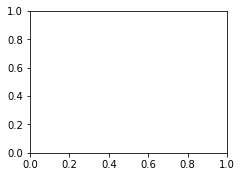

In [14]:
shuffle(X_test)
fig = plt.figure(figsize=(12,12))

for i in range(200,210):
    y = fig.add_subplot(4,3,i-199)
    if np.round(result[i])==0:
        label = 'Cat'
    else:
        label = 'Dog'
    y.imshow(X_test[i].reshape(IMG_SIZE,IMG_SIZE))
    plt.title(label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()